In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount = True)

Mounted at /content/gdrive/


In [ ]:
import sys

sys.path.insert(0, "/content/gdrive/MyDrive")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

full_df = pd.read_csv("/content/gdrive/MyDrive/full_df_2.csv")
half_df = full_df.loc["2016-01-01 00:00:00":"2023-03-12 00:00:00", :]
half_df = full_df[['현재수요(MW)', '공급능력(MW)', '최대예측수요(MW)', '공급예비력(MW)', '공급예비율(퍼센트)',
       '운영예비력(MW)', '운영예비율(퍼센트)', 'mean_temp', 'wind_1', 'wind_2',
       'wind_3', 'wind_4',
       ]]
#half_df.loc[:, "현재수요(MW)"] = MinMaxScaler().fit_transform(np.array(half_df.loc[:, "현재수요(MW)"]).reshape(-1, 1))
del full_df
#print(half_df.shape)

#Time Series Spliiter

def custom_splitter(X, train_size = 512, test_size = 72, step = 10000, enex = True):
  #X.shape = [1140072, 12]
  X = X.astype("float32") #정보형 바꿔서 용량 낮추기
  #X = X.astype("float16") #정보형 바꿔서 용량 낮추기


  #train_size = 내가 설정 가능. 일단 default 는 512
  #test_size = 72. 문제에서 하라고 한 게 이거니까


  len = X.shape[0]
  maginot = len - (train_size + test_size)
  X_array = np.zeros(((maginot//step)+1, train_size, X.shape[1]))



  if enex:
    y_array = np.zeros(((maginot//step)+1, test_size, X.shape[1]))

    for i, m in enumerate(range(0, maginot, step)): #30은 그냥 랜덤한 값. window 간 떨어져 있는 거리. 리소스 다운 때문.
      start_idx = m
      X_end_idx = start_idx + train_size
      y_end_idx = X_end_idx + test_size

      X_data = np.array(X.iloc[start_idx:X_end_idx, :]) #X_data : (512, #features + 1)
      y_data = np.array(X.iloc[X_end_idx:y_end_idx, :]) #y_data : (72, #features + 1)

      X_array[i] = X_data
      y_array[i] = y_data

  else:
    y_array = np.zeros(((maginot//step)+1, test_size))

    for i, m in enumerate(range(0, maginot, step)): #30은 그냥 랜덤한 값. window 간 떨어져 있는 거리. 리소스 다운 때문.
      start_idx = m
      X_end_idx = start_idx + train_size
      y_end_idx = X_end_idx + test_size

      X_data = np.array(X.iloc[start_idx:X_end_idx, :]) #X_data : (512, #features + 1)
      y_data = np.array(X.iloc[X_end_idx:y_end_idx, 0]) #y_data : (72, #features + 1)

      X_array[i] = X_data
      y_array[i] = y_data

  return X_array, y_array


"""
X, Y = custom_splitter(half_df, train_size = 512, test_size = 72, step = 12)
print(X.shape, Y.shape)
"""


def endog_exog(X_splitted, y_splitted):
  X_endog = X_splitted[:, :, 0]
  X_exog = X_splitted[:, :, 1:]
  y_endog = y_splitted[:, :, 0]
  #y_exog = y_splitted[: , :, 1:]

  return X_endog, X_exog, y_endog



"""
X_endog, X_exog, y_endog = endog_exog(X, Y)
print(X_endog.shape, X_exog.shape, y_endog.shape)

#(12384, 216) (12384, 216, 51) (12384, 72)

"""

def time_train_test(X_endogeneous, X_exogeneous, y_endogeneous, test_prop = 0.2):
  length = X_endogeneous.shape[0]
  train_thr = int(np.round(length*(1-test_prop)))
  perm = np.random.permutation(length)
  train_idx = perm[:train_thr]
  test_idx = perm[train_thr:]


  X_endog_train = X_endogeneous[train_idx]
  X_exog_train = X_exogeneous[train_idx]

  y_endog_train = y_endogeneous[train_idx]

  X_endog_test = X_endogeneous[test_idx]
  X_exog_test = X_exogeneous[test_idx]

  y_endog_test = y_endogeneous[test_idx]


  return X_endog_train, X_exog_train, y_endog_train, X_endog_test, X_exog_test, y_endog_test

def dataset_pipeline(df, train_size, test_size, step = 13, test_prop = 0.2, split = False, enex = True):
  X, Y = custom_splitter(df, train_size, test_size, step, enex)
  X_endog, X_exog, y_endog = endog_exog(X, Y)

  if split:

    X_endog_train, X_exog_train, y_endog_train, X_endog_test, X_exog_test, y_endog_test = time_train_test(X_endog, X_exog, y_endog, test_prop)


    return X_endog_train, X_exog_train, y_endog_train, X_endog_test, X_exog_test, y_endog_test

  else:

    return X_endog, X_exog, y_endog


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda')
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
X_endog_train, X_exog_train, y_endog_train, X_endog_test, X_exog_test, y_endog_test = dataset_pipeline(half_df, train_size = 255, test_size = 48, step = 11, test_prop = 0.2, split = True, enex = True)
print(X_endog_train.shape, X_exog_train.shape, y_endog_train.shape, X_endog_test.shape, X_exog_test.shape, y_endog_test.shape)
del half_df


class ElectricityTrainDataset(Dataset):
    def __init__(self, X_endog_train, X_exog_train,
                 y_endog_train):
        self.X_endog_train = torch.FloatTensor(X_endog_train).unsqueeze(1).to(device)
        self.X_exog_train = torch.FloatTensor(X_exog_train).permute(0, 2, 1).to(device)
        self.y_endog_train = torch.FloatTensor(y_endog_train).unsqueeze(1).to(device)
    def __len__(self):
        return self.X_endog_train.shape[0]

    def __getitem__(self, idx):
        return self.X_endog_train[idx], self.X_exog_train[idx], self.y_endog_train[idx]

class ElectricityTestDataset(Dataset):
    def __init__(self, X_endog_test,
                 X_exog_test, y_endog_test):
        self.X_endog_test = torch.FloatTensor(X_endog_test).unsqueeze(1).to(device)
        self.X_exog_test = torch.FloatTensor(X_exog_test).permute(0, 2, 1).to(device)
        self.y_endog_test = torch.FloatTensor(y_endog_test).unsqueeze(1).to(device)

    def __len__(self):
        return self.X_endog_test.shape[0]

    def __getitem__(self, idx):
        return self.X_endog_test[idx], self.X_exog_test[idx], self.y_endog_test[idx]



(82893, 255) (82893, 255, 11) (82893, 48) (20723, 255) (20723, 255, 11) (20723, 48)


In [ ]:
import torch
import numpy as np
import torch.nn as nn

device = torch.device('cuda')


class DCConv1d(torch.nn.Module):
    """Dilated Causal Convolution 1D"""
    def __init__(self, in_channels, out_channels, dilation):
        super(DCConv1d, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_channels, out_channels, kernel_size = 2,
                                     stride = 1, dilation = dilation, padding = 0)

    def forward(self, x):
        #x.shape = [batch_size, 1, input_length]
        output = self.conv1(x)
        return output #[batch_size, out_channels, output_length]
    # output_length = input_length - dilation

class CConv1d(torch.nn.Module):
    """Causal Convolution 1D"""
    def __init__(self, in_channels, out_channels):
        super(CConv1d, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_channels, out_channels, kernel_size = 2,
                                     stride = 1, padding = 1)

    def forward(self, x):
        output = self.conv1(x) #[batch_size, out_channels, output_length]
        #output_length = input_length

        return output[:, :, :-1] #[batch_size, out_channels, input_length]

class Residualblock(torch.nn.Module):
    def __init__(self, res_channels, skip_channels, dilation):
        super(Residualblock, self).__init__()

        self.dc = DCConv1d(res_channels, res_channels, dilation)
        self.conv = torch.nn.Conv1d(in_channels = res_channels, out_channels = res_channels,
                                    kernel_size = 1, stride = 1, padding = 0) #input_length = output_length
        self.skipconv = torch.nn.Conv1d(in_channels = res_channels, out_channels = skip_channels, kernel_size = 1)
        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()

    def forward(self, x, skip_size):
        #x.shape = [batch_size, 1, input_length]
        #skip_len = # points for inference
        output = self.dc(x) #output.shape = [batch_size, out_channels, output_length = input_length - dilation]
        #tanh = self.tanh(output)
        #sigmoid = self.sigmoid(output)
        #gates = tanh * sigmoid
        gates = self.relu(output)
        #gates.shape = [batch_size, out_channels, output_length = input_length - dilation]

        output = self.conv(gates) #[batch_size, out_channels, input_length - dilation]
        input = x[:, :, -(output.size(2)):]
        res = output + input #[batch_size, out_channels, input_length - dilation]

        skip = self.skipconv(gates) #[batch_size, skip_channels, input_length - dilation]

        return res, skip[:, :, -skip_size:] #res.shape = [batch_size, res_channels, input_length - dilation], skip.shape = [batch_size, skip_channels, skip_len]

class ResidualStack(torch.nn.Module):

    def __init__(self, layers, stacks, in_channels, res_channels, skip_channels):
        super(ResidualStack, self).__init__()
        self.layers = layers
        self.stacks = stacks
        self.in_channels = in_channels
        self.res_blocks = nn.ModuleList()
        for dilation in self.build_dilations():
            block = Residualblock(res_channels, skip_channels, dilation)
            self.res_blocks.append(block)
    def build_dilations(self):
        dilations = []
        for s in range(0, self.stacks): #0, 1, 2, 3, 4...
            for l in range(0, self.layers): #0, 1, 2, ...
                dilations.append(2 ** l)
        return dilations


    def forward(self, x, skip_size):
        #x.shape = [batch_size, 1, input_length]
        #skip_len = # points for inference

        output = x
        skip_connections = []
        for res_block in self.res_blocks:
            output, skips = res_block(output, skip_size)
            skip_connections.append(skips)
        skip_connections = torch.stack(skip_connections)
        return skip_connections

class clf_net(torch.nn.Module):
    def __init__(self, skip_channels, channels, skip_size):
        super(clf_net, self).__init__()

        #self.conv1 = torch.nn.Conv1d(in_channels = channels, out_channels = channels,
        #                             kernel_size = 1)
        #self.conv2 = torch.nn.Conv1d(in_channels = channels, out_channels = channels , kernel_size = 1)
        self.maxpool = nn.MaxPool1d(2)
        self.relu = torch.nn.ReLU()
        self.flatten = nn.Flatten()
        #self.linear1 = torch.nn.Linear(skip_size*skip_channels, 1)
        self.linear1 = torch.nn.LazyLinear(128)
        self.linear2 = torch.nn.Linear(128, 1)
    def forward(self, x):
        #x.shape = [batch_size, skip_channels, 1]
        #output = x.squeeze(2)
        #output = self.linear1(output)

        #output = self.conv1(output) #[batch_size, skip_channels * n, 1]
        #output = self.relu(output)
        #output = self.conv2(output).permute(0, 2, 1) #[batch_size, skip_channels * n, 1]
        output = self.relu(x) #[batch_size, skip_channels, 1]
        #output = self.flatten(output)
        output = output.transpose(2, 1)
        #output = self.relu(output)
        output = self.linear1(output)
        output = self.relu(output)
        output = self.linear2(output)
        return output


class Wavenet(torch.nn.Module):
    def __init__(self, layers, stacks, in_channels, res_channels, skip_channels):
        super(Wavenet, self).__init__()
        self.causal = CConv1d(in_channels = in_channels, out_channels = res_channels)
        self.res_stack = ResidualStack(layers, stacks, res_channels, res_channels, skip_channels)
        self.receptive_fields = self.calc_receptive_fields(layers, stacks)
        self.clf_net = clf_net(skip_channels, skip_channels, self.calc_receptive_fields)

    @staticmethod
    def calc_receptive_fields(layer_size, stack_size):
        layers = [2 ** i for i in range(0, layer_size)] * stack_size
        num_receptive_fields = np.sum(layers)

        return int(num_receptive_fields)

    def calc_output_size(self, x):
        output_size = int(x.size(2)) - self.receptive_fields

        #self.check_input_size(x, output_size)

        return output_size
    def forward(self, x):
        #x.shape = [batch_size, in_channels = 1, input_length]
        output = x
        output_size = self.calc_output_size(x)
        output = self.causal(output) #[batch_size, out_channels, input_length]
        #output = self.causal2(output)
        skip_connections = self.res_stack(output, output_size)

        output_ = torch.sum(skip_connections, dim = 0)
        output = self.clf_net(output_)

        return output #[batch_size, 1, 1]

"""
model = Wavenet(6, 4, 1, 512, 64).to(device)
a = torch.rand([16, 1, 256]).to(device)
print(model(a).shape)
"""

'\nmodel = Wavenet(6, 4, 1, 512, 64).to(device)\na = torch.rand([16, 1, 256]).to(device)\nprint(model(a).shape)\n'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import torch
import os
import datetime
torch.manual_seed(156)
device = torch.device('cuda')
save_path = "/content/gdrive/MyDrive"
wavenet = torch.load(os.path.join(save_path, 'lastmodel.pt'))



def auto_infer(model, X_endog, X_exog, y_endog, input_len, output_len):
  model.eval()
  model.to(device)
  samples = X_endog.shape[0]
  idx = np.random.choice(samples - 1)
  full_array = np.zeros([1, 1, X_endog.shape[1] + output_len])
  full_array[:, :, :input_len] = X_endog[idx, :]
  infer_array = np.zeros([output_len])
  gt = y_endog[idx, :]
  for i in range(output_len):

    input_array = full_array[:, :, i:i+input_len]
    input = torch.FloatTensor(input_array).to(device)
    output = model(input)
    full_array[:, :, input_len+i] = output.cpu().detach().numpy()
    infer_array[i] = output.reshape(-1).cpu().detach().numpy()


  return X_endog[idx, :], y_endog[idx, :], full_array, infer_array, gt

#inferred = auto_infer(wavenet, X_endog_test, X_exog_test, y_endog_test, 512, 72)


def generate_time_index(start_time, length_in_minutes):
  end_time = start_time + datetime.timedelta(minutes=length_in_minutes)

  time_index = []

  # Generate time index with 5-minute intervals
  current_time = start_time
  while current_time < end_time:
    time_index.append(current_time)
    current_time += datetime.timedelta(minutes=5)

  return time_index

def plot_inferred(infer_array, gt, pred_timestep):
  infer_array = infer_array.reshape(-1)
  gt = gt.reshape(-1)
  mape = mean_absolute_percentage_error(infer_array, gt)
  title = "autoregressive wavenet || " + "mape: " + str(mape)
  time_idx = generate_time_index(start_time = datetime.datetime(2020, 1, 1, 9, 0), length_in_minutes = int(5*pred_timestep))
  fig = plt.figure(figsize=(8, 8))
  fig.set_facecolor('white')
  ax = fig.add_subplot()

  ax.plot(time_idx, infer_array, marker='o', label='pred')
  ax.plot(time_idx, gt, marker='v', label='target')
  plt.title(title)
  plt.legend()
  plt.show()







In [ ]:
def auto_infer(model, X_endog, X_exog, y_endog, input_len, pred_len, output_len):
  model.eval()
  model.to(device)
  samples = X_endog.shape[0]
  idx = np.random.choice(samples - 1)
  full_array = np.zeros([1, 1, X_endog.shape[1] + output_len])
  full_array[:, :, :input_len] = X_endog[idx, :]
  infer_array = np.zeros([1, pred_len])
  gt = y_endog[idx, :]
  for i in range(0, output_len, pred_len):

    input_array = full_array[:, :, i:i+input_len]
    input = torch.FloatTensor(input_array).to(device)
    output = model(input)
    full_array[:, :, input_len+i:input_len+i+pred_len] = output.transpose(2, 1).cpu().detach().numpy()
    infer_array[0] = output.reshape(-1).cpu().detach().numpy()

  return X_endog[idx, :], y_endog[idx, :], full_array, infer_array, gt

In [ ]:
#a = torch.rand([1, 1, 512]).to(device)
wavenet(a)

tensor([[[0.7332]]], device='cuda:0', grad_fn=<PermuteBackward0>)

In [ ]:
a[0, 0, 0] = 5143
wavenet(a)

tensor([[[3977.7629]]], device='cuda:0', grad_fn=<PermuteBackward0>)

In [ ]:
X_endog

In [ ]:
gt.shape

(48,)

In [ ]:
gt.shape

(1,)

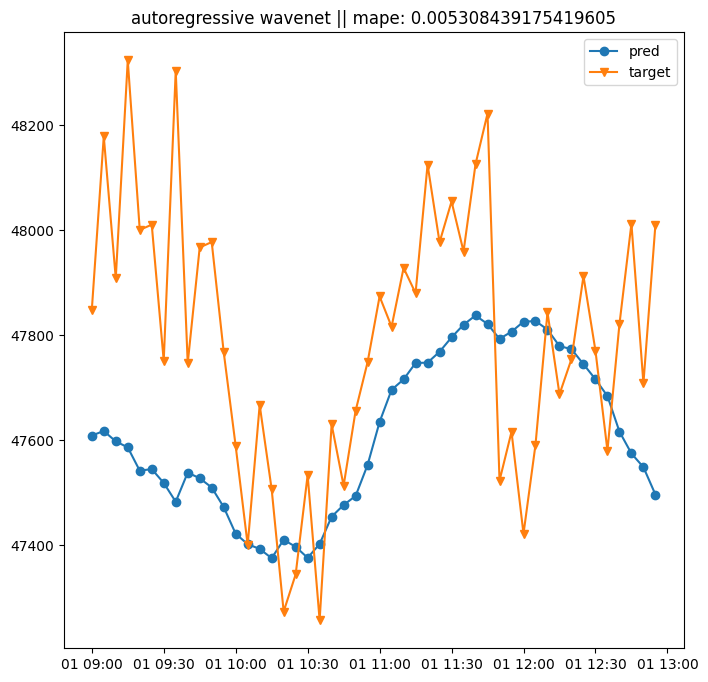

In [ ]:
#last model work
X_endog, y_endog, full_array, infer_array, gt = auto_infer(wavenet, X_endog_train, X_exog_train, y_endog_train, 255, 48)
plot_inferred(infer_array.reshape(-1), gt, 48)

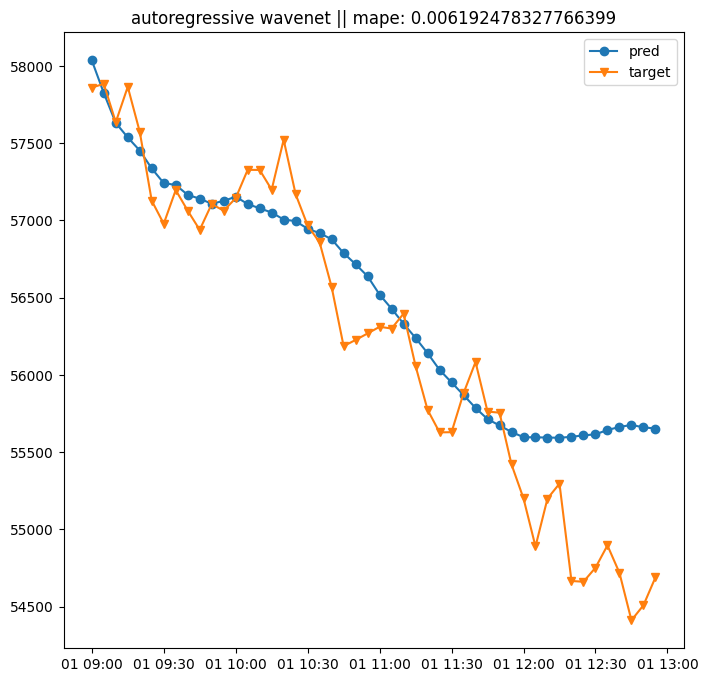

In [ ]:
#last model work
X_endog, y_endog, full_array, infer_array, gt = auto_infer(wavenet, X_endog_train, X_exog_train, y_endog_train, 255, 48)
plot_inferred(infer_array.reshape(-1), gt, 48)

In [ ]:
X_endog, y_endog, full_array, infer_array, gt = auto_infer(wavenet, X_endog_train, X_exog_train, y_endog_train, 302, 48, 48)

TypeError: auto_infer() takes 6 positional arguments but 7 were given

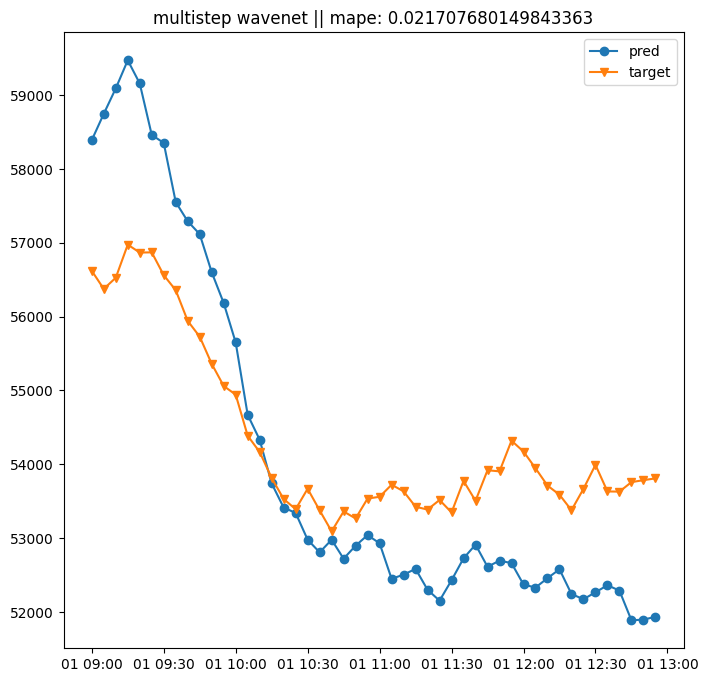

In [ ]:
plot_inferred(infer_array.reshape(-1), gt, 48)

In [ ]:
X_endog, y_endog, full_array, infer_array, gt = auto_infer(wavenet, X_endog_train, X_exog_train, y_endog_train, 302, 48, 48)
plot_inferred(infer_array.reshape(-1), gt, 48)

array([0.35719153, 0.35611758, 0.35486278, 0.35345867, 0.35218808,
       0.35084751, 0.34955987, 0.34826922, 0.34699598, 0.3457343 ,
       0.34448454, 0.3432475 , 0.34202212, 0.34080884, 0.33960733,
       0.33841753, 0.3372393 , 0.33607259, 0.33491722, 0.33377311,
       0.33264014, 0.3315182 , 0.3304072 , 0.32930702, 0.32821754,
       0.32713866, 0.32607031, 0.32501236, 0.32396469, 0.32292724,
       0.32189986, 0.32088253, 0.31987509, 0.31887746, 0.31788957,
       0.31691128, 0.31594256, 0.31498334, 0.31403345, 0.31309289,
       0.31216151, 0.31123924, 0.31032598, 0.30942166, 0.30852616,
       0.30763942, 0.30676138, 0.30589187, 0.30503088, 0.3041783 ,
       0.30333412, 0.3024981 , 0.30167028, 0.30085057, 0.30003887,
       0.29923511, 0.2984392 , 0.29765105, 0.29687062, 0.29609782,
       0.29533258, 0.2945748 , 0.29382446, 0.29308146, 0.2923457 ,
       0.29161713, 0.2908957 , 0.29018131, 0.28947392, 0.28877342,
       0.28807977, 0.28739291])

In [ ]:
full_array

In [ ]:
gt

array([0.35145262, 0.35865986, 0.35798359, 0.35854465, 0.3563512 ,
       0.35580349, 0.34879231, 0.34754622, 0.3519761 , 0.34839022,
       0.35006812, 0.3533439 , 0.34692195, 0.34601372, 0.35585296,
       0.35324588, 0.35523951, 0.35693544, 0.35506731, 0.35247982,
       0.34899423, 0.35291812, 0.35279056, 0.3520681 , 0.35199291,
       0.3527236 , 0.35251209, 0.35342994, 0.35001558, 0.3509585 ,
       0.35465199, 0.3507607 , 0.35364094, 0.35933354, 0.3570908 ,
       0.36020643, 0.36348787, 0.36410439, 0.36688659, 0.36632499,
       0.37097412, 0.37133774, 0.37124366, 0.37017852, 0.37338632,
       0.36968628, 0.36783618, 0.37614739, 0.37585294, 0.38303512,
       0.3858161 , 0.3861255 , 0.38629049, 0.38616842, 0.38773558,
       0.39180112, 0.3916502 , 0.39395183, 0.40043062, 0.4047192 ,
       0.41581154, 0.40869528, 0.40849906, 0.41291451, 0.41958436,
       0.42298481, 0.42422679, 0.42962188, 0.42808238, 0.43004715,
       0.43432456, 0.44491938])

In [ ]:
X_endog, y_endog, full_array, infer_array, gt = auto_infer(wavenet, X_endog_test, X_exog_test, y_endog_test, 190, 72)
plot_inferred(infer_array, gt)

RuntimeError: Given groups=1, weight of size [512, 512, 2], expected input[1, 256, 190] to have 512 channels, but got 256 channels instead